In [1]:
import os
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

In [2]:
N = 5
logtheta_loc = torch.tensor([0.,0.,1000.,0.,0.])
logtheta_scale = torch.ones(N)*1#torch.tensor([.001, .001, .001, .001, .001])
logtheta = pyro.sample("logtheta", dist.LogisticNormal(logtheta_loc, logtheta_scale))
theta = F.softmax(logtheta, -1)
theta, dist.Categorical(theta).sample()

(tensor([0.1350, 0.1456, 0.3219, 0.1325, 0.1325, 0.1325]), tensor(2))

In [3]:
# d = dist.Normal(logtheta_loc, logtheta_scale).to_event(1)
# x = d.sample()
# x
dist.Categorical(theta).sample()

tensor(1)

In [4]:
dist.LogisticNormal(logtheta_loc, logtheta_scale).sample()

tensor([9.4109e-02, 2.7449e-01, 6.3140e-01, 7.7443e-09, 3.7289e-08, 3.0236e-08])

In [5]:
import torch
import pyro
import matplotlib.pyplot as plt
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroParam, PyroSample
from pyro.infer import config_enumerate
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.optim import Adam, ClippedAdam
from torch.distributions import constraints
import torch.nn.functional as F
import torch.nn as nn
from pyro import poutine

In [6]:
from tqdm import trange
import numpy as np

In [7]:
z_ind = 3

data = np.load(f"../../data/raw/numerical_sim_{z_ind}.npz",allow_pickle=True)
Z = data['mat_Z'].flatten()[::2]
f = data['f'].flatten()[::2]

exp_data = torch.cat((torch.tensor(Z.imag), torch.tensor(Z.real)),0).float().unsqueeze(-1).float().t()
# test2 = exp_data.t().float()
# exp_f = torch.tensor(f)
# N_data = len(exp_data)
# exp_f.dtype

s = torch.tensor(2*np.pi*f.astype(np.float32)*1j).unsqueeze(-1)

exp_data = torch.cat((torch.tensor(Z.imag), torch.tensor(Z.real)),0).float().unsqueeze(-1)
train_data = exp_data.t().float()

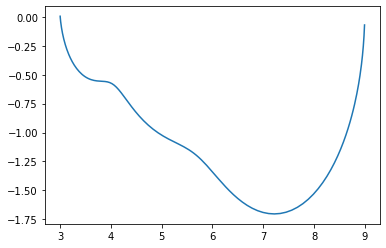

In [8]:
plt.plot(Z.real, Z.imag)

In [9]:
Ndata = len(s)
class RTau(PyroModule):
    def __init__(self, parent_name, R, tau, alfa, s, i):
        super().__init__(name=f'{parent_name}_Rtau_{i}')
        self.R = PyroParam(R, constraint=constraints.positive)
        self.tau = PyroParam(tau, constraint=constraints.interval(-4.,4.))
        self.alfa = PyroParam(alfa, constraint=constraints.half_open_interval(.65,.99))
        self.s = s
        self.__number = i
        
    def forward(self):
        # if self.__number > number_pole:
        #     return Z
        # powa = torch.pow(self.s,self.alfa)
        # rq = 1 + torch.mul(powa,self.Q * self.R)
        rq = 1+torch.pow(self.s*torch.pow(10,self.tau),self.alfa)
        Z = self.R*torch.pow(rq,-1)
        return Z.squeeze()

class EIS(PyroModule):
    def __init__(self, name:str, Rs:torch.tensor, R:torch.tensor, tau:torch.tensor, alfa:torch.tensor, s:torch.tensor, L:torch.tensor = 0):
        super().__init__(name=name)
        self.L = L
        self.s = s
        self.Rs = PyroParam(Rs, constraint=constraints.positive)

        if R.shape != tau.shape:
            raise Exception('R and tau must have the same shape')
        if tau.shape != alfa.shape:
            raise Exception('tau and alfa must have the same shape')
        self.RTaus = PyroModule[nn.Sequential](*[RTau(name, R[i], tau[i], alfa[i], s, i+1) for i in range(len(R))])
        

    def forward(self):
        # if pole is None:
        #     pole = len(self.RQs)
        # pole = pole - 1
        # Z = self.Rs + self.s*self.L
        # for num, module in enumerate(self.RQs):
        #     if num > pole:
        #         break
        #     Z = module(Z)
        # # Z = self.RQs({'Z':Z,'number_pole':pole})
        Zser = self.Rs + self.s*self.L
        Z = torch.vstack([m() for m in self.RTaus]).T #+  Zser.unsqueeze(-1)
        # return Z
        # print(Z.sum(dim=-1).shape, Zser.shape)
        Z = Z.sum(dim=-1) + Zser.squeeze()
        # return Z

        y = torch.cat((Z.imag, Z.real),0)
        y = y.t()
        return y.squeeze()

class EISModel(PyroModule):
    def __init__(self, Rs:torch.tensor, R:torch.tensor, tau:torch.tensor, alfa:torch.tensor, s:torch.tensor, L:torch.tensor = 0, separate_parameters = True):
        super().__init__()
        if separate_parameters:
            self.models = [EIS(f'EIS_{i}', Rs, R[:i], tau[:i], alfa[:i], s, L) for i in range(1,len(R)+1)]
        else:
            self.models = [EIS(f'EIS', Rs, R[:i], tau[:i], alfa[:i], s, L) for i in range(1,len(R)+1)]

    def forward(self, poles):
        if poles.ndim > 0:
            # Z = torch.vstack([self.models[p](x) for p in poles])#.to(torch.float32)
            Z = torch.vstack([self.models[p]() for p in poles])
        else:
            Z = self.models[poles]()
            Z.unsqueeze(0)
        return Z.squeeze()


class ModelSimple:
    def __init__(self, max_dim, Rs:torch.tensor, R:torch.tensor, s:torch.tensor, tau_min:torch.tensor, tau_max:torch.tensor, L:torch.tensor = 0):
        # super().__init__()
        # self.eis_model = EIS('EIS',Rs, R, Q, alfa, s, L)  
        # tau_prior = torch.zeros(max_dim)
        # tau_prior = torch.linspace(torch.log10(tau_min)+1, torch.log10(tau_max)-1, max_dim)
        tau_prior = dist.Normal(torch.tensor(0.), torch.tensor(0.1)).sample([max_dim])
        print(tau_prior)
        self.eis_model = EISModel(Rs, R = torch.ones(max_dim)*R, tau=tau_prior, alfa=torch.ones(max_dim)*0.8, s=s, L=L,separate_parameters=True)  
        self.obs_scale = torch.tensor(1.e-3)
        self.s = s
        self.max_dim = max_dim

    # @poutine.scale(scale=1.0/(2*Ndata))
    @config_enumerate
    def model(self, output):
        # N_par = pyro.param('N_par', dist.Dirichlet(torch.ones(N)*200), constraint=constraints.simplex)
        logtheta_loc = pyro.param('theta_loc',torch.ones(self.max_dim))
        logtheta_scale = pyro.param('theta_scale',torch.ones(self.max_dim)*0.1)
        logtheta = pyro.sample("logtheta", dist.Normal(torch.zeros(self.max_dim), torch.ones(self.max_dim)*1).to_event(1))
        N_par = F.softmax(logtheta, -1)
        # N_par = pyro.sample("logtheta", dist.LogisticNormal(torch.zeros(self.max_dim-1), torch.ones(self.max_dim-1)*1))

        pole = pyro.sample('N_asg', dist.Categorical(N_par))#.squeeze().item()+1
        
        obs_loc = self.eis_model(pole)  # this samples linear.bias and linear.weight
        obs_scale = self.obs_scale    # this samples self.obs_scale
        factor = torch.lgamma(pole+2)#*3 + torch.log(torch.tensor(2.)) + torch.log(torch.tensor(len(self.s)))
        pyro.factor('K_factor',factor) 
        with pyro.plate("instances", 2*len(self.s)):
            return pyro.sample("obs", dist.Normal(obs_loc, obs_scale),
                               obs=output)
    @config_enumerate
    def guide(self, output):
        # N_par = pyro.param('N_par', dist.Dirichlet(torch.ones(N)*200), constraint=constraints.simplex)
        logtheta_loc = pyro.param('theta_loc',torch.zeros(self.max_dim))
        logtheta_scale = pyro.param('theta_scale',torch.ones(self.max_dim)*1, constraint=constraints.positive)
        logtheta = pyro.sample("logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
        # logtheta = pyro.sample("logtheta", dist.LogisticNormal(logtheta_loc, logtheta_scale))
        N_par = F.softmax(logtheta, -1)
        pole = pyro.sample('N_asg', dist.Categorical(N_par))#.squeeze().item()+1

In [10]:
L_t=torch.tensor(1e-7)

R_t=torch.tensor([1.,2.,3.,4.,5.])
old_Q=torch.tensor([.1,1.,10.,100.,1000.])
alfa_t=torch.tensor([0.88,0.82,0.99,.90,.93])
taus_t = torch.pow(R_t*old_Q,1/alfa_t)

# test = EIS('3',torch.tensor(3.),R_t[:3],taus_t[:3],alfa_t[:3],s, L_t)
# zt = test().detach().numpy()
# # zt.shape
# zt0 = test.RTaus[0]().squeeze()#.detach().numpy()
# zt1 = test.RTaus[1]().squeeze()#.detach().numpy()
# torch.vstack([zt0, zt1]).shape
# # plt.plot(zt.real, zt.imag)
# zt = torch.vstack([m() for m in test.RTaus])
# zt.shape
# plt.plot(zt.real, zt.imag)
# zt.shape

# N = 7
# m = ModelSimple(N, s=s,  R = torch.tensor(1.), Rs = torch.tensor(1.), tau_min = torch.tensor(1/f.max()) , tau_max = torch.tensor(1/f.min()))# sigma=torch.tensor(1e-5))
# m.model(train_data)

In [11]:
(torch.log10(torch.tensor(1/f.max()) ), torch.log10(torch.tensor(1/f.min()) ), 7)

(tensor(-3.9840, dtype=torch.float64), tensor(4., dtype=torch.float64), 7)

In [12]:
torch.pow(10,torch.tensor(-3.2))

tensor(0.0006)

In [22]:
N = 7
m = ModelSimple(N, s=s,  R = torch.tensor(1.), Rs = torch.tensor(1.), tau_min = torch.tensor(1/f.max()) , tau_max = torch.tensor(1/f.min()))# sigma=torch.tensor(1e-5))

tensor([ 0.1981,  0.0204,  0.0191, -0.0119, -0.0184, -0.1197,  0.1522])


In [43]:


# reg  = MultipleModels(N)

reset = False
its=3000 #and the number of iterations 12500

def per_param_callable(module_name, param_name):
    # return {"lr": 0.01}
    if 'theta_' in param_name:
        return {"lr": 0.01,'betas': (0.95, 0.999)}
    # elif 'tau' in param_name:
    #     return {"lr": 1,'betas': (0.95, 0.999)}
    else:
        return {"lr": 0.05,'betas': (0.95, 0.999)}


optimizer = Adam(per_param_callable)
pbar = trange(its)
if reset:
    pyro.clear_param_store()
    pyro.enable_validation(True)
    
    
    eloss = []
    N_progress = []
    N_progress_scale = []
    
    svi = SVI(m.model,
            m.guide,
            optim = optimizer,#Adam({"lr": .001}),
            # optim=scheduler,
            loss=TraceEnum_ELBO(max_plate_nesting=1,num_particles=1,vectorize_particles=False)
             )


for i in pbar:
    elbo = svi.step(train_data)#only parameter for this function is the data
    eloss.append(elbo)   #store elbo values for progression overview
    N_progress.append(pyro.param("theta_loc").clone().cpu().detach().numpy()) #store pole values for progression overview
    N_progress_scale.append(pyro.param("theta_scale").clone().cpu().detach().numpy()) #store pole values for progression overview
    
    if i % 100 == 0:
        # pbar.set_description(f"elbo is: {np.log10(elbo):.2f} lr={scheduler.get_state()['alfa_a']['scheduler']['_last_lr'][0]:.2e}")
        pbar.set_description(f"elbo is: {np.log10(elbo):.2f}")
        # print(str(i)+"-th iteration, elbo is: " + str(elbo) +'\n')
    # i+=1
    # break
    # scheduler.step()

elbo is: 5.06:  27%|██▋       | 799/3000 [00:25<01:10, 31.27it/s]/tmp/ipykernel_2850195/2412513388.py:43: RuntimeWarning: invalid value encountered in log10
  pbar.set_description(f"elbo is: {np.log10(elbo):.2f}")
elbo is: 3.20: 100%|██████████| 3000/3000 [01:34<00:00, 31.59it/s]


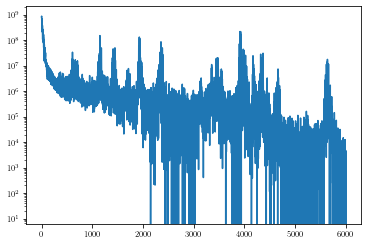

In [44]:
plt.semilogy(eloss)

Text(0, 0.5, 'Probability')

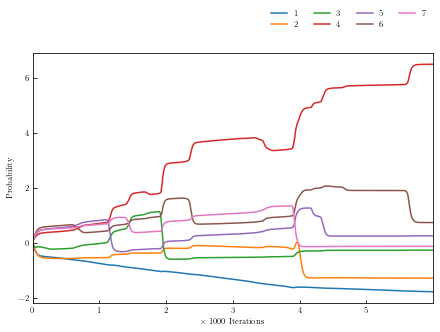

In [45]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=8)
fig, ax = plt.subplots(figsize=(6.0,4.5))
fig.set_constrained_layout(True)
N_progress_plot=np.array(N_progress)
x_progress = np.arange(len(N_progress_plot))*1e-3
for i in range(0,N):
    ax.plot(x_progress, N_progress_plot[:,i], label=f'{i+1}')
    # break
ax.legend(frameon=False, bbox_to_anchor=(1., 1.2),prop={"size": 8}, ncols=4)
ax.set_xlim(0,x_progress.max())
plt.tick_params(axis='both', which='both', direction='in')
plt.xlabel(r'$\times$ 1000 Iterations')
plt.ylabel('Probability')

# fig.savefig('../../reports/figures/poles_N_separate_params.pdf',bbox_inches='tight')

Text(0, 0.5, 'Probability')

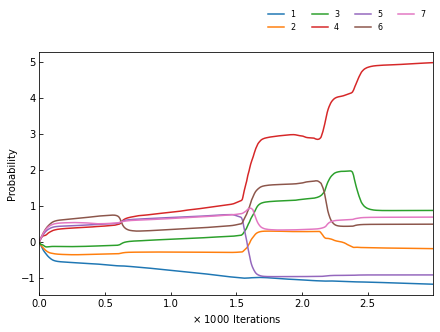

In [45]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=8)
fig, ax = plt.subplots(figsize=(6.0,4.5))
fig.set_constrained_layout(True)
N_progress_plot=np.array(N_progress)
x_progress = np.arange(len(N_progress_plot))*1e-3
for i in range(0,N):
    ax.plot(x_progress, N_progress_plot[:,i], label=f'{i+1}')
    # break
ax.legend(frameon=False, bbox_to_anchor=(1., 1.2),prop={"size": 8}, ncols=4)
ax.set_xlim(0,x_progress.max())
plt.tick_params(axis='both', which='both', direction='in')
plt.xlabel(r'$\times$ 1000 Iterations')
plt.ylabel('Probability')

# fig.savefig('../../reports/figures/poles_N_separate_params.pdf',bbox_inches='tight')

In [50]:
# torch.save({'N_progress':N_progress,'eloss':eloss}, f'{out_prefix}_model.pt')
xx = pyro.get_param_store().get_state()
for k,v in xx['params'].items():
    xx['params'][k] = v.to('cpu')
torch.save(xx, f'logisticnormal_3_model_pyro.pt')

In [26]:
# logtheta_loc = torch.zeros(N)#torch.tensor([0.,0.,10.,0.,0.])
# logtheta_scale = torch.ones(N)*.1#torch.tensor([.001, .001, .001, .001, .001])
logtheta = pyro.sample("logtheta", dist.Normal(torch.tensor(N_progress[-1]), torch.tensor(N_progress_scale[-1])))
theta = F.softmax(logtheta, -1)
theta,dist.Categorical(theta).sample()

(tensor([0.0029, 0.0062, 0.0028, 0.9272, 0.0016, 0.0520, 0.0074]), tensor(3))

In [27]:
all_poles = []
for i in trange(len(N_progress)):
    logtheta = pyro.sample("logtheta", dist.Normal(torch.tensor(N_progress[i]), torch.tensor(N_progress_scale[i])))
    theta = F.softmax(logtheta, -1)
    sel_pole = dist.Categorical(theta).sample([100])
    sel_pole = sel_pole.numpy()
    a,b = np.histogram(sel_pole,bins=np.arange(N+1),density=True)
    all_poles.append(a)

100%|██████████| 3000/3000 [00:00<00:00, 4577.86it/s]


In [28]:
YY.shape, np.array(all_poles).shape

NameError: name 'YY' is not defined

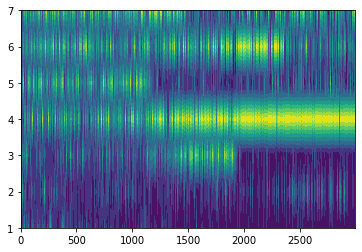

In [29]:
# plt.imshow(np.array(all_poles),aspect=.001)
XX,YY = np.meshgrid(np.arange(3000), np.arange(1,N+1))
plt.contourf(XX,YY,np.array(all_poles).T,levels=10);
# plt.pcolormesh(np.array(all_poles).T, shading='gouraud')

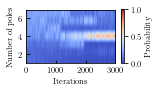

In [30]:
from scipy.ndimage import gaussian_filter
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
plt.figure(figsize=(6/3, 4.5/3))
# Apply Gaussian filter for smoothing
smoothed_data = gaussian_filter(np.array(all_poles), sigma=[0, 1e-4])  # Adjust sigma as needed
extent = [0, 3000, 1, 7] 
plt.imshow(np.flipud(smoothed_data.T), aspect=300,cmap='coolwarm', extent = extent)
plt.colorbar(shrink=.665,label='Probability')
plt.xlabel('Iterations')
plt.ylabel('Number of poles')
plt.tick_params(axis='both', which='both', direction='in')
# plt.savefig('../../reports/figures/logistic_norm.pdf', bbox_inches='tight')

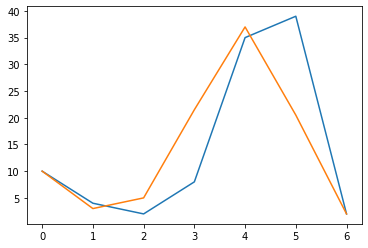

In [153]:
plt.plot(all_poles[0])
plt.plot(smoothed_data[0])

In [68]:
N_est = 5
R_e = [pyro.get_param_store()[f'EIS_{N_est}.RTaus.{i}.R'] for i in range(N_est)]
tau_e = [pyro.get_param_store()[f'EIS_{N_est}.RTaus.{i}.tau'] for i in range(N_est)]
alpha_e = [pyro.get_param_store()[f'EIS_{N_est}.RTaus.{i}.alfa'] for i in range(N_est)]


R_e, tau_e, torch.log10(taus_t), alpha_e

([tensor(0.0147, grad_fn=<AddBackward0>),
  tensor(1.9524, grad_fn=<AddBackward0>),
  tensor(1.0010, grad_fn=<AddBackward0>),
  tensor(1.1511, grad_fn=<AddBackward0>),
  tensor(1.8920, grad_fn=<AddBackward0>)],
 [tensor(-3.9979, grad_fn=<AddBackward0>),
  tensor(0.3564, grad_fn=<AddBackward0>),
  tensor(-1.1330, grad_fn=<AddBackward0>),
  tensor(1.4770, grad_fn=<AddBackward0>),
  tensor(1.4952, grad_fn=<AddBackward0>)],
 tensor([-1.1364,  0.3671,  1.4920,  2.8912,  3.9774]),
 [tensor(0.6500, grad_fn=<AddBackward0>),
  tensor(0.8293, grad_fn=<AddBackward0>),
  tensor(0.8853, grad_fn=<AddBackward0>),
  tensor(0.9783, grad_fn=<AddBackward0>),
  tensor(0.9900, grad_fn=<AddBackward0>)])

In [34]:
from pyro.infer import Predictive

#To visualize the spread we sample 1000 different model outputs, to obtain 1000 sampled EIS curves.
num_samples = 50
predictive = Predictive(model=m.model,
        guide=m.guide, num_samples=num_samples)
data = predictive(None)

In [49]:
torch.save(data, f'../../data/processed/logist_result_3.pt')

In [52]:
data = torch.load(f'../../data/processed/logist_result_3.pt')

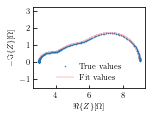

In [60]:
# fig, ax = plt.subplots(figsize=(6.25,4))
plt.figure(figsize=(6/3, 4.5/3))
yt = data['obs'].cpu().detach().numpy().T.squeeze()
plt.plot(train_data[0,len(s):],-1*train_data[0,:len(s)], '.', markersize=1., label='True values',zorder=50);
plt.plot(yt[len(s):,1:],-1*yt[:len(s),1:],'pink', alpha=0.7);
plt.plot(yt[len(s):,0],-1*yt[:len(s),0],'pink', alpha=0.7,label='Fit values');
plt.legend(loc='best',frameon=False)
plt.axis('equal')
plt.xlabel('$\Re{\{Z\}}[\Omega]$')
plt.ylabel('$-\Im{\{Z\}}[\Omega]$')
plt.tick_params(axis='both', which='both', direction='in')
plt.savefig('../../reports/figures/logist_fit.pdf',bbox_inches='tight')

In [69]:
pyro.get_param_store().keys()

dict_keys(['theta_loc', 'theta_scale', 'EIS_1.Rs', 'EIS_1.RTaus.0.tau', 'EIS_1.RTaus.0.alfa', 'EIS_1.RTaus.0.R', 'EIS_2.Rs', 'EIS_2.RTaus.0.tau', 'EIS_2.RTaus.0.alfa', 'EIS_2.RTaus.0.R', 'EIS_2.RTaus.1.tau', 'EIS_2.RTaus.1.alfa', 'EIS_2.RTaus.1.R', 'EIS_3.Rs', 'EIS_3.RTaus.0.tau', 'EIS_3.RTaus.0.alfa', 'EIS_3.RTaus.0.R', 'EIS_3.RTaus.1.tau', 'EIS_3.RTaus.1.alfa', 'EIS_3.RTaus.1.R', 'EIS_3.RTaus.2.tau', 'EIS_3.RTaus.2.alfa', 'EIS_3.RTaus.2.R', 'EIS_4.Rs', 'EIS_4.RTaus.0.tau', 'EIS_4.RTaus.0.alfa', 'EIS_4.RTaus.0.R', 'EIS_4.RTaus.1.tau', 'EIS_4.RTaus.1.alfa', 'EIS_4.RTaus.1.R', 'EIS_4.RTaus.2.tau', 'EIS_4.RTaus.2.alfa', 'EIS_4.RTaus.2.R', 'EIS_4.RTaus.3.tau', 'EIS_4.RTaus.3.alfa', 'EIS_4.RTaus.3.R', 'EIS_5.Rs', 'EIS_5.RTaus.0.tau', 'EIS_5.RTaus.0.alfa', 'EIS_5.RTaus.0.R', 'EIS_5.RTaus.1.tau', 'EIS_5.RTaus.1.alfa', 'EIS_5.RTaus.1.R', 'EIS_5.RTaus.2.tau', 'EIS_5.RTaus.2.alfa', 'EIS_5.RTaus.2.R', 'EIS_5.RTaus.3.tau', 'EIS_5.RTaus.3.alfa', 'EIS_5.RTaus.3.R', 'EIS_5.RTaus.4.tau', 'EIS_5.RTaus

In [46]:
from pyro.infer import Predictive

#To visualize the spread we sample 1000 different model outputs, to obtain 1000 sampled EIS curves.
num_samples = 50
predictive = Predictive(model=m.model,
        guide=m.guide, num_samples=num_samples)
data = predictive(None)

(2.6960708856582642,
 9.305165553092957,
 -0.09088372348342091,
 1.7912846175255255)

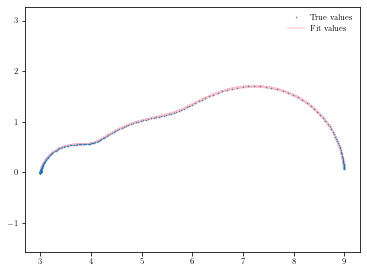

In [47]:


# fig, ax = plt.subplots(figsize=(6.25,4))
plt.figure(figsize=(6, 4.5))
yt = data['obs'].cpu().detach().numpy().T.squeeze()
plt.plot(train_data[0,len(s):],-1*train_data[0,:len(s)], '.', markersize=1., label='True values',zorder=50);
plt.plot(yt[len(s):,1:],-1*yt[:len(s),1:],'pink', alpha=0.7);
plt.plot(yt[len(s):,0],-1*yt[:len(s),0],'pink', alpha=0.7,label='Fit values');
plt.legend(loc='best',frameon=False)
plt.axis('equal')
# plt.savefig('../../reports/figures/logist_fit.pdf',bbox_inches='tight')